# Sebastian Schneck
## Arbeitsprobe:
## Abschlussprojekt *Certified Data Scientist*


<h1>Aufgabenstellung</h1>

1. Bestimme die Schlüsselfaktoren, die die Verkaufs- bzw. Umsatzerlöse beeinflussen und stelle geeignete Strategien für das Management-Team für die zukünftige Geschäftsplanung bereit. 

2. Baue ein vereinheitlichtes Prognosemodell auf (z.B. mit Hilfe einer einfachen Zeitreihenmodellierung) für jede Filiale auf der Grundlage der historischen Verkaufsdaten oder mit zusätzlichen Schlüsselvariablen, falls erforderlich, um sicherzustellen, dass das Modell besser abschneidet als die durchschnittliche Methode (Mittelwertmethode - Prognose mit dem Durchschnittswert der historischen Daten). 

3. Generiere Berichte mit Informationen zur Gesamtleistung der 1115 Filialen sowie individueller Leistungsberichte für jede Filiale.


<h1>Inhaltsverzeichnis</h1>

<a href='#00.'>00. Allgemeine Schritte</a><br>
<a href='#00.1'>&nbsp;&nbsp;&nbsp;00.1 Datensatz 'train'</a><br>
<a href='#00.2'>&nbsp;&nbsp;&nbsp;00.2 Datensatz 'store'</a><br>
<a href='#00.3'>&nbsp;&nbsp;&nbsp;00.3 Erstellen eines gemeinsamen Datensatzes</a><br>
<a href='#01.'>01. Datenanalyse</a><br>
<a href='#02.'>02. Modellbildung</a><br>
<a href='#03.'>03. Filialberichte</a><br>

# 00. Allgemeine Schritte

In [1]:
#Import der wichtigsten, allgemeinen Bibliotheken
#weitere, spezielle Bibliotheken werden ggf. an Ort und Stelle importiert
import numpy as np
import pandas as pd
import random as rd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [2]:
#Einlesen der Datensätze
store = pd.read_csv('store.csv')
train = pd.read_csv('train.csv', low_memory=False)

Allgemeiner Überblick über die Daten
- Umfang
- Beschaffenheit: fehlende Daten?
- Liegen verarbeitungsfähige Datentypen vor?

<h1>00.1 Datensatz 'train'</h1>

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Die Spalte 'Date' wird in den Dtype: 'datetime' umzuwandeln sein, da es um Zeitreihen gehen wird.<br>
Es wird zudem auf Wochenebene aggregiert.<br>
Die Spalte im Dtype: 'object' kann so nicht bleiben. Was wird hier genau kodiert?

In [4]:
train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

keine fehlenden Daten (NaN)<br>Dies schließt die Existenz von Nullwerten natürlich nicht aus.

In [5]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Die allgemeinen Statistiken sind hier nur für 'Sales' und 'Customers' aussagekräftig.<br>
Es gibt Ausreißer.<br>
Es wird vor der Modellierung ggf. eine Umskalierung notwendig sein.

Betrachtung einiger Stichproben und des Tabellenkopfes

In [6]:
train.sample(5).sort_index()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
109929,660,5,2015-04-24,4171,482,1,0,0,0
325356,189,6,2014-09-27,6774,670,1,0,0,0
438532,8,2,2014-06-03,7251,764,1,1,0,0
461823,999,3,2014-05-14,6786,533,1,0,0,0
634997,233,1,2013-12-09,10390,1159,1,0,0,0


In [7]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Mit Blick auf die Aufgabenstellung richte ich einen Multiindex ein, jeder Store erhält eine Zeitreihe.<br>
Ein Multiindex nach Store-Nummer ermöglicht es komfortabel, für jedes Geschäft dessen Performance übers Jahr abzurufen.

In [8]:
train['Date']=pd.to_datetime(train['Date'])

In [9]:
train_id=train.copy().set_index(['Store','Date']).sort_index()

In [10]:
train_id.sample(5).sort_index()

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
88    2014-09-19          5   6000        624     1      1            0   
181   2013-03-13          3   4951        575     1      0            0   
      2014-04-20          7      0          0     0      0            0   
207   2015-05-05          2  12900       1354     1      1            0   
637   2015-06-27          6   7884        616     1      0            0   

                  SchoolHoliday  
Store Date                       
88    2014-09-19              0  
181   2013-03-13              0  
      2014-04-20              0  
207   2015-05-05              0  
637   2015-06-27              0

In [11]:
train_id.head()

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
1     2013-01-01          2      0          0     0      0            a   
      2013-01-02          3   5530        668     1      0            0   
      2013-01-03          4   4327        578     1      0            0   
      2013-01-04          5   4486        619     1      0            0   
      2013-01-05          6   4997        635     1      0            0   

                  SchoolHoliday  
Store Date                       
1     2013-01-01              1  
      2013-01-02              1  
      2013-01-03              1  
      2013-01-04              1  
      2013-01-05              1

Es ist ein Gewinn an Übersichtlichkeit zu verzeichnen.

Die Daten sollen für die Bearbeitung der Aufgabenstellung auf Wochenebene aggregiert werden.<br>
Es ist zu beachten, dass hierbei möglichst wenig tagesbezogene Informationen verloren gehen:</br>
- dies betriftt hier vor allem die Feiertage und Ferientage
- das Osterwochenende liegt bspw. inmitten zweier "4-Tage-Wochen"
- bspw. Ostersonntag fällt auf einen Wochentag, an dem viele Filialen ohnehin geschlossen hätten
- auch andere Feiertage fallen periodisch oder jährlich mit Sonntagen zusammen

In [12]:
train_id.loc[577,:]['Promo'].resample(rule='W').sum().value_counts()

5    72
0    63
Name: Promo, dtype: int64

Offenbar gibt es Promo-Wochen und Nicht-Promo-Wochen.

In [13]:
train_id[train_id['StateHoliday']=='b']['DayOfWeek'].value_counts()

5    3345
1    3345
Name: DayOfWeek, dtype: int64

Bei der Kategorie 'b' handelt es sich offenbar um Ostersonntage und Karfreitage.
<br><br>
Ich werde zu Osterwochen zusammenfassen.

In [14]:
train_id[train_id['StateHoliday']=='c']['DayOfWeek'].value_counts()

4    2050
3    1115
5     935
Name: DayOfWeek, dtype: int64

Im betrachteten Zeitraum fällt Weihnachten stets auf einen Arbeitstag.

Die betreffende Woche werde ich zur 'Weihnachtswoche' ernennen.

In [15]:
train_id[train_id['SchoolHoliday']==1]['DayOfWeek'].value_counts()

2    36595
5    36235
4    34747
3    34636
1    34060
6     2724
7     2724
Name: DayOfWeek, dtype: int64

Offenkundig ist es nicht einheitlich, ob Ferienwochenenden als solche ausgewiesen sind.

In [16]:
train_id.sort_index().loc[569,:]['SchoolHoliday'].resample(rule='W').sum().value_counts()

0    94
5    31
1     6
3     2
4     1
2     1
Name: SchoolHoliday, dtype: int64

In [17]:
train_id[(train_id['SchoolHoliday']==1)&(train_id['DayOfWeek']>5)]

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
1     2013-01-05          6   4997        635     1      0            0   
      2013-01-06          7      0          0     0      0            0   
      2013-07-06          6   4090        498     1      0            0   
      2013-07-07          7      0          0     0      0            0   
      2013-07-13          6   4015        490     1      0            0   
...                     ...    ...        ...   ...    ...          ...   
1115  2014-12-28          7      0          0     0      0            0   
      2015-01-03          6   6468        469     1      0            0   
      2015-01-04          7      0          0     0      0            0   
      2015-04-04          6  10444        717     1      0            0   
      2015-04-05          7      0          0     0      0            0   

                  SchoolHoliday  
Store Date                       
1     2013-01-05              1  
      2013-01-06              1  
      2013-07-06              1  
      2013-07-07              1  
      2013-07-13              1  
...                         ...  
1115  2014-12-28              1  
      2015-01-03              1  
      2015-01-04              1  
      2015-04-04              1  
      2015-04-05              1  

[5448 rows x 7 columns]

Ich werde hier 'SchoolHoliday' gleich Null setzen, da diese Tage ohnehin schulfrei sind und die die Mehrzahl der Shops so verfährt.
<br>So lässt sich einheitlich mit der Anz. der Ferientage pro Woche operieren.
<br>Die folgenden Stores erklären auch Feriensamstage und -sonntage zu 'SchoolHolidays'. Für künftige Analysen könnte hier ein einheitliches Vorgehen angeregt werden.

In [18]:
train_id[(train_id['SchoolHoliday']==1)&(train_id['DayOfWeek']>5)].droplevel(1, axis=0).index.value_counts().sort_index()

1       40
10      44
56      40
69      40
70      44
        ..
1084    40
1086    40
1087    44
1103    40
1115    40
Name: Store, Length: 134, dtype: int64

In [19]:
#Nullsetzen von 'SchoolHoliday' an Feriensamstagen und -sonntagen
train_id.loc[(train_id['SchoolHoliday']==1)&(train_id['DayOfWeek']>5),'SchoolHoliday'] = 0

In [20]:
train_id[(train_id['Open']==1)&(train_id['StateHoliday']!='0')]

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
2     2013-10-03          4   2656        381     1      0            a   
      2014-10-03          5   2689        389     1      1            a   
5     2013-05-30          4   5065        576     1      1            a   
      2014-06-19          4   5307        574     1      1            a   
      2015-06-04          4   5807        625     1      1            a   
...                     ...    ...        ...   ...    ...          ...   
1099  2015-05-25          1   4971        732     1      0            a   
1107  2013-08-15          4   6138        649     1      1            a   
1108  2013-05-30          4   6555        675     1      1            a   
      2014-06-19          4   7037        703     1      1            a   
      2015-06-04          4   7404        693     1      1            a   

                  SchoolHoliday  
Store Date                       
2     2013-10-03              0  
      2014-10-03              0  
5     2013-05-30              0  
      2014-06-19              0  
      2015-06-04              0  
...                         ...  
1099  2015-05-25              0  
1107  2013-08-15              1  
1108  2013-05-30              0  
      2014-06-19              0  
      2015-06-04              0  

[910 rows x 7 columns]

Diese Filialen hatten an den jeweiligen Feiertagen geöffnet. Dies bleibt im Vergleich zu den geschlossenen Stores später über den Wert 'Open' summiert auf 7 Tage sichtbar.

Die kategorialen Variblen 'StateHoliday' und 'DayOfWeek' werden im Folgenden 'One-Hot-kodiert' in schließlich drei bzw. sieben Dummy-Variablen.

In [21]:
ohe = OneHotEncoder(sparse_output=False,dtype='int64')

In [22]:
ohe.fit(train_id['StateHoliday'].values.reshape(-1, 1))

OneHotEncoder(dtype='int64', sparse_output=False)

In [23]:
ohe.categories_

[array(['0', 'a', 'b', 'c'], dtype=object)]

In [24]:
df=pd.DataFrame(ohe.transform(train_id['StateHoliday'].values.reshape(-1, 1)),index=train_id.index,columns=['NoHoliday','OtherHoliday','Easter','Xmas'])

In [25]:
ohe.fit(train_id['DayOfWeek'].values.reshape(-1, 1))

OneHotEncoder(dtype='int64', sparse_output=False)

In [26]:
ohe.categories_

[array([1, 2, 3, 4, 5, 6, 7])]

In [27]:
df_dow=pd.DataFrame(ohe.transform(train_id['DayOfWeek'].values.reshape(-1, 1)),index=train_id.index,columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [28]:
train_ohe=pd.concat([train_id,df,df_dow],axis=1)

In [29]:
train_ohe.drop(columns=['DayOfWeek','StateHoliday','NoHoliday'],inplace=True)

In [30]:
train_ohe.head()

Sales  Customers  Open  Promo  SchoolHoliday  OtherHoliday  \
Store Date                                                                     
1     2013-01-01      0          0     0      0              1             1   
      2013-01-02   5530        668     1      0              1             0   
      2013-01-03   4327        578     1      0              1             0   
      2013-01-04   4486        619     1      0              1             0   
      2013-01-05   4997        635     1      0              0             0   

                  Easter  Xmas  Monday  Tuesday  Wednesday  Thursday  Friday  \
Store Date                                                                     
1     2013-01-01       0     0       0        1          0         0       0   
      2013-01-02       0     0       0        0          1         0       0   
      2013-01-03       0     0       0        0          0         1       0   
      2013-01-04       0     0       0        0          0         0       1   
      2013-01-05       0     0       0        0          0         0       0   

                  Saturday  Sunday  
Store Date                          
1     2013-01-01         0       0  
      2013-01-02         0       0  
      2013-01-03         0       0  
      2013-01-04         0       0  
      2013-01-05         1       0

In [31]:
train_o2 = train_ohe.copy()

Ich möchte die entstandenen zehn Variablen vor der Aggregation auf Wochenebene weiter zusammenfassen.<br>
Meine Überlegung ist, dass ein Feiertag, der auf einen Sonntag fällt für den Wochenrythmus der Kundschaft keinen Untschied macht.<br>
Auch am Samstag fällt kein Werktag weg. <br>
Hingegen bedeutet ein Feiertag an einem Montag oder Freitag nicht nur einen Tag weniger Umsatz für den Store sondern auch ein langes Wochenende für die Kunden, analog gibt es potentielle Brückentage.


In [32]:
train_o2['LongWE'] = np.zeros(len(train_o2),dtype='int64')
train_o2['Bridge'] = np.zeros(len(train_o2),dtype='int64')
train_o2['HoliSat'] = np.zeros(len(train_o2),dtype='int64')
train_o2['HoliWed'] = np.zeros(len(train_o2),dtype='int64')

In [33]:
train_o2.loc[(train_o2['OtherHoliday']==1) & (train_o2['Monday']==1),'LongWE']=1
train_o2.loc[(train_o2['OtherHoliday']==1) & (train_o2['Friday']==1),'LongWE']=1
train_o2.loc[(train_o2['OtherHoliday']==1) & (train_o2['Tuesday']==1),'Bridge']=1
train_o2.loc[(train_o2['OtherHoliday']==1) & (train_o2['Thursday']==1),'Bridge']=1
train_o2.loc[(train_o2['OtherHoliday']==1) & (train_o2['Saturday']==1),'HoliSat']=1
train_o2.loc[(train_o2['OtherHoliday']==1) & (train_o2['Wednesday']==1),'HoliWed']=1

In [34]:
train_o2.drop(columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','OtherHoliday'],inplace=True)

Nun kann das das DataFrame auf Wochenebene erstellt werden.

In [35]:
list=[]
i=1
for i in range(1,1116):
    list.append(train_o2.loc[i,:].resample(rule='W').sum())

In [36]:
weekly_sales_o2 = pd.concat(list,keys=range(1,1116),names=['Store','Date'])

In [37]:
train_weekly=weekly_sales_o2.copy()

Ich verändere nun noch die Information über Promo zu einer kategorialen Variable.

In [38]:
weekly_sales_o2['Promo'].value_counts()

5    77580
0    72765
1      180
Name: Promo, dtype: int64

In [39]:
weekly_sales_o2[weekly_sales_o2['Promo']==1].sample(5)

,,Sales,Customers,Open,Promo,SchoolHoliday,Easter,Xmas,LongWE,Bridge,HoliSat,HoliWed
Store,Date,,,,,,,,,,,
159,2014-07-06,13540,1016,1,1,0,0,0,0,0,0,0
974,2014-07-06,14915,1942,1,1,0,0,0,0,0,0,0
1104,2014-07-06,9960,630,1,1,0,0,0,0,0,0,0
41,2014-07-06,9086,626,1,1,0,0,0,0,0,0,0
766,2014-07-06,9035,673,1,1,0,0,0,0,0,0,0


In [40]:
weekly_sales_o2[(weekly_sales_o2['Promo']==1)&(weekly_sales_o2['Open']>1)].count()

Sales            0
Customers        0
Open             0
Promo            0
SchoolHoliday    0
Easter           0
Xmas             0
LongWE           0
Bridge           0
HoliSat          0
HoliWed          0
dtype: int64

In [41]:
weekly_sales_o2.loc[(279,'2014-07'):(279,'2015')].head()

Sales  Customers  Open  Promo  SchoolHoliday  Easter  Xmas  \
Store Date                                                                     
279   2014-07-06  24429       1456     1      1              0       0     0   
      2014-07-13      0          0     0      0              0       0     0   
      2014-07-20      0          0     0      0              0       0     0   
      2014-07-27      0          0     0      0              0       0     0   
      2014-08-03      0          0     0      0              0       0     0   

                  LongWE  Bridge  HoliSat  HoliWed  
Store Date                                          
279   2014-07-06       0       0        0        0  
      2014-07-13       0       0        0        0  
      2014-07-20       0       0        0        0  
      2014-07-27       0       0        0        0  
      2014-08-03       0       0        0        0

In [42]:
print('Durschnittstagesumsatz einer betroffenen Filiale 2013: {p:.2f}'.format(p=train_o2.loc[(279,'2013'),'Sales'].mean()))
print('...und am letzten Tag vor der Schließung: {p:.2f}'.format(p=train_o2.loc[(279,'2014-06-30'),'Sales']))

Durschnittstagesumsatz einer betroffenen Filiale 2013: 6527.24
...und am letzten Tag vor der Schließung: 24429.00


Manche Stores hatten in manchen Wochen nur einen Tag geöffnet und dieser war ein Promo-Tag. Es folgt hier eine längere Schließung. Möglicherweise ging dieser ein Räumungsverlauf mit Promo-Aktionen voraus. Letztgültig lässt sich dies nur mit Insider-Wissen beantworten. An dieser Stelle geht es um die Umwandlung in eine kategoriable Variable und es liegt ein sehr seltener Fall vor.

In [43]:
train_weekly['Promo'].replace({1:0,5:1},inplace=True)

In [44]:
train_weekly['Xmas'].value_counts()

0    148475
2      2050
Name: Xmas, dtype: int64

Die Variables 'Xmas' ist fortan zu begreifen als: Weihnachtswoche ja/nein

In [45]:
train_weekly['Xmas'].replace(2,1,inplace=True)

In [46]:
train_weekly[train_weekly['HoliSat']==1]

,,Sales,Customers,Open,Promo,SchoolHoliday,Easter,Xmas,LongWE,Bridge,HoliSat,HoliWed
Store,Date,,,,,,,,,,,
3,2014-11-02,26454,3451,5,0,0,0,0,0,0,1,0
9,2014-11-02,31128,3012,5,0,0,0,0,0,0,1,0
14,2014-11-02,26178,3360,5,0,0,0,0,0,0,1,0
16,2014-11-02,38589,4495,5,0,4,0,0,0,0,1,0
19,2014-11-02,31322,3333,5,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1097,2014-11-02,79714,17885,7,0,5,0,0,0,0,1,0
1100,2014-11-02,20830,3067,5,0,0,0,0,0,0,1,0
1105,2014-11-02,20507,2608,5,0,0,0,0,0,0,1,0


Mittels der neuen Variable 'HoliSat' lässt sich der Fall Allerseelen 2014 aufspüren. Aber es bei der geringen Zahl von Datenpunkten nicht davon auszugehen, dass diese Variable im Weiteren relant sein wird. Möglicherweise wird deshalb spätestens für die Modellbildung doch eine allgemeine Lösung für die Feiertage etabliert. Zunächst könnte man aber im Weiteren schauen, ob bspw. Brückentage den Umsatz beeinflussen. 
<br><br>
Grundsätzlich liegt dieser Datensatz nun in einer Form vor, mit der an die Aufgaben herangegangen werden kann.

# 00.2 Datensatz 'store'

In [47]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [48]:
store.sample(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1025,1026,c,a,450.0,6.0,2011.0,1,48.0,2012.0,"Mar,Jun,Sept,Dec"
54,55,a,a,720.0,11.0,2004.0,0,NaN,NaN,NaN
825,826,a,c,7980.0,6.0,2005.0,0,NaN,NaN,NaN
725,726,a,c,40540.0,2.0,2002.0,0,NaN,NaN,NaN
220,221,d,c,13530.0,9.0,2013.0,0,NaN,NaN,NaN


In [49]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [50]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


Analog zu 'train' wähle ich Store als neuen Index.<br>
Bei 'CompetitionDistance' sind drei fehlende Werte zu ergänzen. Ich entscheide mich für den Median, der Mittelwert dürfte durch (unrealistische?) Ausreißer stark verfälscht sein.<br>

In [51]:
store.set_index('Store', inplace=True)

In [52]:
store.loc[store['CompetitionDistance'].isna(),'CompetitionDistance']=store['CompetitionDistance'].median()

In [53]:
store['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [54]:
store['PromoInterval'].replace({'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3},inplace=True)

Die Werte in Floating-Point-Numbers sind nicht optimal codiert (z.B. Entfernung auf cm genau?).

In [55]:
stores=store.convert_dtypes()

In [56]:
stores.dtypes

StoreType                    string
Assortment                   string
CompetitionDistance           Int64
CompetitionOpenSinceMonth     Int64
CompetitionOpenSinceYear      Int64
Promo2                        Int64
Promo2SinceWeek               Int64
Promo2SinceYear               Int64
PromoInterval                 Int64
dtype: object

In [57]:
stores.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270,9,2008,0,<NA>,<NA>,<NA>
2,a,a,570,11,2007,1,13,2010,1
3,a,a,14130,12,2006,1,14,2011,1
4,c,c,620,9,2009,0,<NA>,<NA>,<NA>
5,a,a,29910,4,2015,0,<NA>,<NA>,<NA>


In [58]:
stores[stores['Promo2']==1].isna().sum()

StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    206
CompetitionOpenSinceYear     206
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

Fürs Erste möchte ich hier keine weiteren Entscheidungen treffen.<br>
Diese Meta-Informationen fließen nicht (maschinell) in die Modellbildung ein. <br>
Die fehlenden Werte bei der Konkurrenzeröffnung können nicht sinnvoll ergänzt werden. Wo vorhanden, können sie einen etwaigen Umsatzeinbruch erklären helfen.<br>
Die NaN-Werte bei 'Promo...' sind folgerichtig, wenn es keine Promo2 gibt. Wo es sie gibt, wurden auch die anhängigen Daten aufgezeichnet.<br>
Fällt die Einführung derselben in den Zeitraum von 'train', ist ihr Einfluss aufs Ergebnis interessant.

# 00.3 Erstellen eines gemeinsamen Datensatzes

Die Zahlen zu Verkäufen, Kundenanzahlen, Öffnungstagen, Promotionen/Werbeaktionen und Feiertagen von 1115 Geschäften soll auf Basis der Gesamtsumme der 942 Tage aggregiert werden. <br>
Neue Metriken machen die Zahlen der einzelnen Filialen untereinader vergleichbar, auch wenn manche möglicherweise längere Zeit geschlossen waren. Dies sind:
- der durchschnittliche tägliche Verkaufserlös
- die durchschnittliche tägliche Kundenanzahl
- die Verkäufe pro Kunde

In [59]:
train_store=train_weekly.groupby('Store').sum()

In [60]:
train_store

,Sales,Customers,Open,Promo,SchoolHoliday,Easter,Xmas,LongWE,Bridge,HoliSat,HoliWed
Store,,,,,,,,,,,
1,3716854,440523,781,72,153,6,2,5,10,0,2
2,3883858,457855,784,72,167,6,2,6,7,0,2
3,5408261,584310,779,72,170,6,2,6,10,1,2
4,7556507,1036254,784,72,173,6,2,5,7,0,2
5,3642818,418588,779,72,172,6,2,6,11,0,4
...,...,...,...,...,...,...,...,...,...,...,...
1111,4091076,351883,779,72,170,6,2,6,10,1,2
1112,7974294,653276,779,72,170,6,2,6,10,1,2
1113,5196242,562151,784,72,159,6,2,5,7,0,2


Der einzelne Promo-Tag darf wieder hinzu.
Es wurde auf Weihnachtswochen reduziert, nun zählen wir wieder die Weihnachtstage, analog zu anderen Feiertagen.
Im Weiteren werden alle Feiertage zusammenaddiert, weil die Differenzierung auf Gesamtebene sicherlich nicht aussagekräftig ist.

In [61]:
train_store.loc[:,'Promo']=train_store['Promo']*5

In [62]:
train_store.loc[weekly_sales_o2[weekly_sales_o2['Promo']==1].index.droplevel('Date'),'Promo']=train_store.loc[weekly_sales_o2[weekly_sales_o2['Promo']==1].index.droplevel('Date'),'Promo']+1

In [63]:
train_store.loc[:,'Xmas']=train_store['Xmas']*2

In [64]:
train_store['StateHolidays']=train_store['Easter']+train_store['Xmas']+train_store['LongWE']+train_store['Bridge']+train_store['HoliSat']+train_store['HoliWed']

In [65]:
train_store.drop(columns=['Easter','Xmas','LongWE','Bridge','HoliSat','HoliWed'],inplace=True)

Nun werden die drei neuen Variablen erstellt.

In [66]:
train_store['SalesPerDay']=train_store['Sales']/train_store['Open']
train_store['CustomersPerDay']=train_store['Customers']/train_store['Open']
train_store['SalesPerCustomer']=train_store['Sales']/train_store['Customers']

In [67]:
train_store_copy=train_store.copy()

In [68]:
train_stores=pd.concat([train_store,stores],axis=1)

In [69]:
#ggf. werden diese kat. Var. numerisch codiert
#train_stores.StoreType=train_stores.StoreType.map({'a':1,'b':2,'c':3,'d':4})
#train_stores.Assortment=train_stores.Assortment.map({'a':1,'b':2,'c':3})

# 01. Datenanalyse

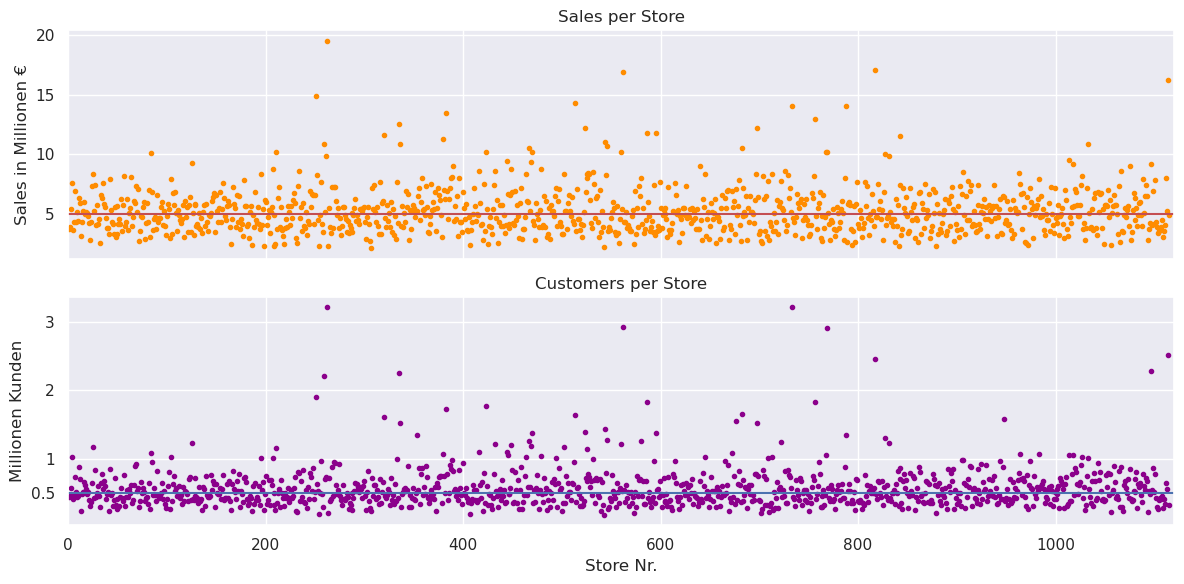

In [70]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(12,6))

axes[0].scatter(train_stores.index,train_stores['Sales'],color="#FF8C00",marker='.')
axes[1].scatter(train_stores.index,train_stores['Customers'],color="#8B008B",marker='.')
axes[0].axhline(y=train_stores['Sales'].median(),color='r')
axes[1].axhline(y=train_stores['Customers'].median())
    
axes[1].set_xlabel('Store Nr.')

axes[0].set_ylabel('Sales in Millionen €')
axes[0].set_title('Sales per Store')
axes[0].set_yticks([5000000.,10000000.,15000000.,20000000.],[5,10,15,20])
axes[0].set_xticks([   0.,  200.,  400.,  600.,  800., 1000.],[])

for ax in axes:
    ax.set_xlim([0,1120])

axes[1].set_ylabel('Millionen Kunden')
axes[1].set_title('Customers per Store')
axes[1].set_yticks([500000.,1000000.,2000000.,3000000.],[.5,1,2,3])


fig.tight_layout()

Zunächst ein Überblick über die absoluten Zahlen über den betrachteten Gesamtzeitraum. Wir sehen jeweils pro Store das absolute Umsatzergebnis und die Zahl der Kunden. Zur Orientierung ist der Median-Wert aller Stores als Linie hervorgehoben.<br>
Dieser liegt jeweils fast genau bei 5.000.000 € bzw. 500.000 Kunden, nämlich ganz genau bei:

In [71]:
print('Median Sales: {a:.0f}€'.format(a=train_stores['Sales'].median()))
print('Median Kunden: {a:.0f}'.format(a=train_stores['Customers'].median()))

Median Sales: 4990259€
Median Kunden: 509233


Was ist denn bei Stores los, die viele Kunden aufweisen, aber bei den Sales nicht nach oben hervorstechen?

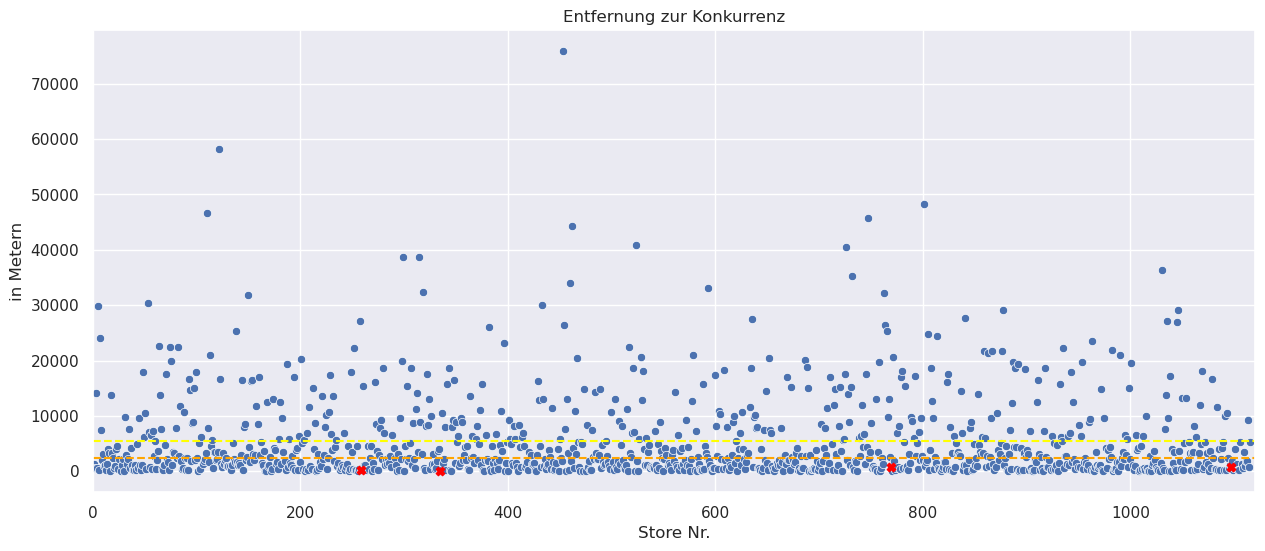

In [72]:
fig,ax1 = plt.subplots(figsize=(15,6))

ser=train_stores.loc[(train_stores['Customers']>2000000)&(train_stores['Sales']<13000000),'CompetitionDistance']

ax1=sns.scatterplot(data=train_stores['CompetitionDistance'])
ax1.axhline(y=train_stores['CompetitionDistance'].median(),color='orange',ls='--')
ax1.axhline(y=train_stores['CompetitionDistance'].mean(),color='yellow',ls='--')
ax1.set_xlim([0,1120])
ax1.set_xlabel('Store Nr.')
ax1.set_ylabel('in Metern')
ax1.set_title('Entfernung zur Konkurrenz')
plt.scatter(ser.index,ser,marker='X',color='red');

In [73]:
train_stores.loc[(train_stores['Customers']>2000000)&(train_stores['Sales']<13000000),['Sales','Customers','SalesPerCustomer','Assortment','CompetitionDistance']]

,Sales,Customers,SalesPerCustomer,Assortment,CompetitionDistance
Store,,,,,
259,10851871,2210980,4.908172,b,210
335,12541731,2246936,5.581704,a,90
769,10198000,2902351,3.513703,b,840
1097,9179413,2280508,4.025161,b,720


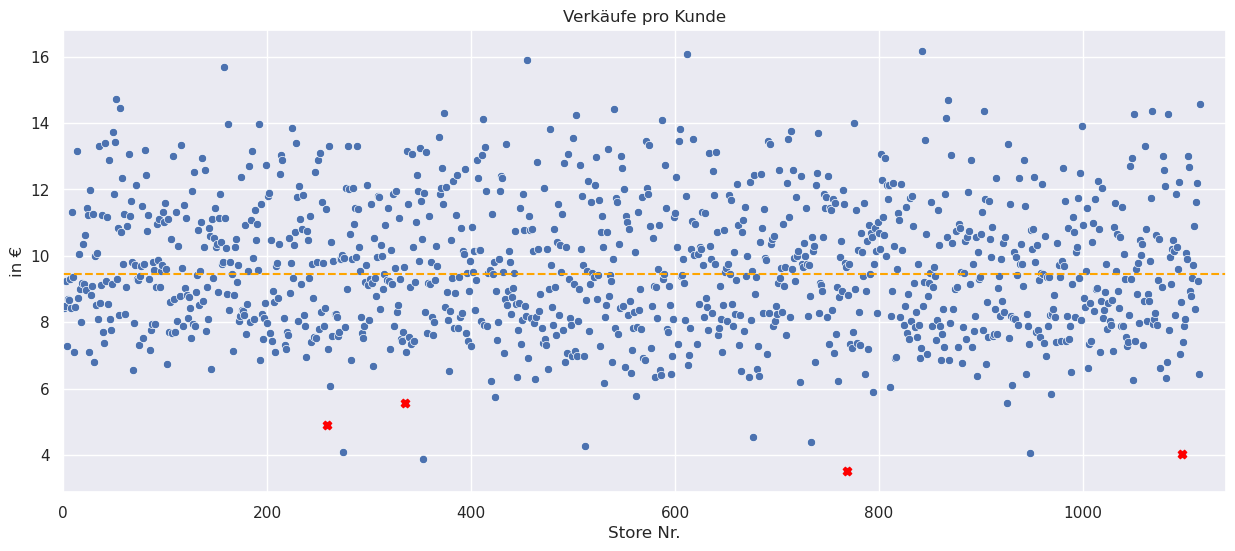

In [74]:
fig,ax = plt.subplots(figsize=(15,6))

ax=sns.scatterplot(data=train_stores,x='Store',y='SalesPerCustomer')

ax.axhline(y=train_stores['SalesPerCustomer'].median(),color='orange',ls='--')
ax.set_xlim([0,1140])
ax.set_xlabel('Store Nr.')
ax.set_ylabel('in €')
ax.set_title('Verkäufe pro Kunde')

plt.scatter(ser.index,train_stores.loc[ser.index,'SalesPerCustomer'],marker='X',color='red');

Diese Stores haben jedenfalls mit überdurchschnittlich nahegelegener Konkurrenz zu kämpfen. Sicherlich Innenstadtgebiet Großstadt, viel Laufkundschaft, aber auch viele Alternativen. Was auffällt, ist, dass der Store mit dem geringsten Sortiment hier im Vergleich sowohl bei den absoluten Zahlen als auch bei den Verkäufen pro Kunde vorn liegt. Um mir eine spezielle Augencreme zu kaufen, werde ich vielleicht nicht unbedingt die Filiale Hamburg Hauptbahnhof ansteuern, wohl aber um mir vor der Abfahrt rasch Artikel eines übersichtlichen Sortiments zu kaufen.

Ich wähle aus den insgesamt 18 Kategorien diejenigen aus, zwischen denen sich möglicherweise paarweise Abhängigkeiten erkennen lassen. Hierzu folgen drei Abbildungen.

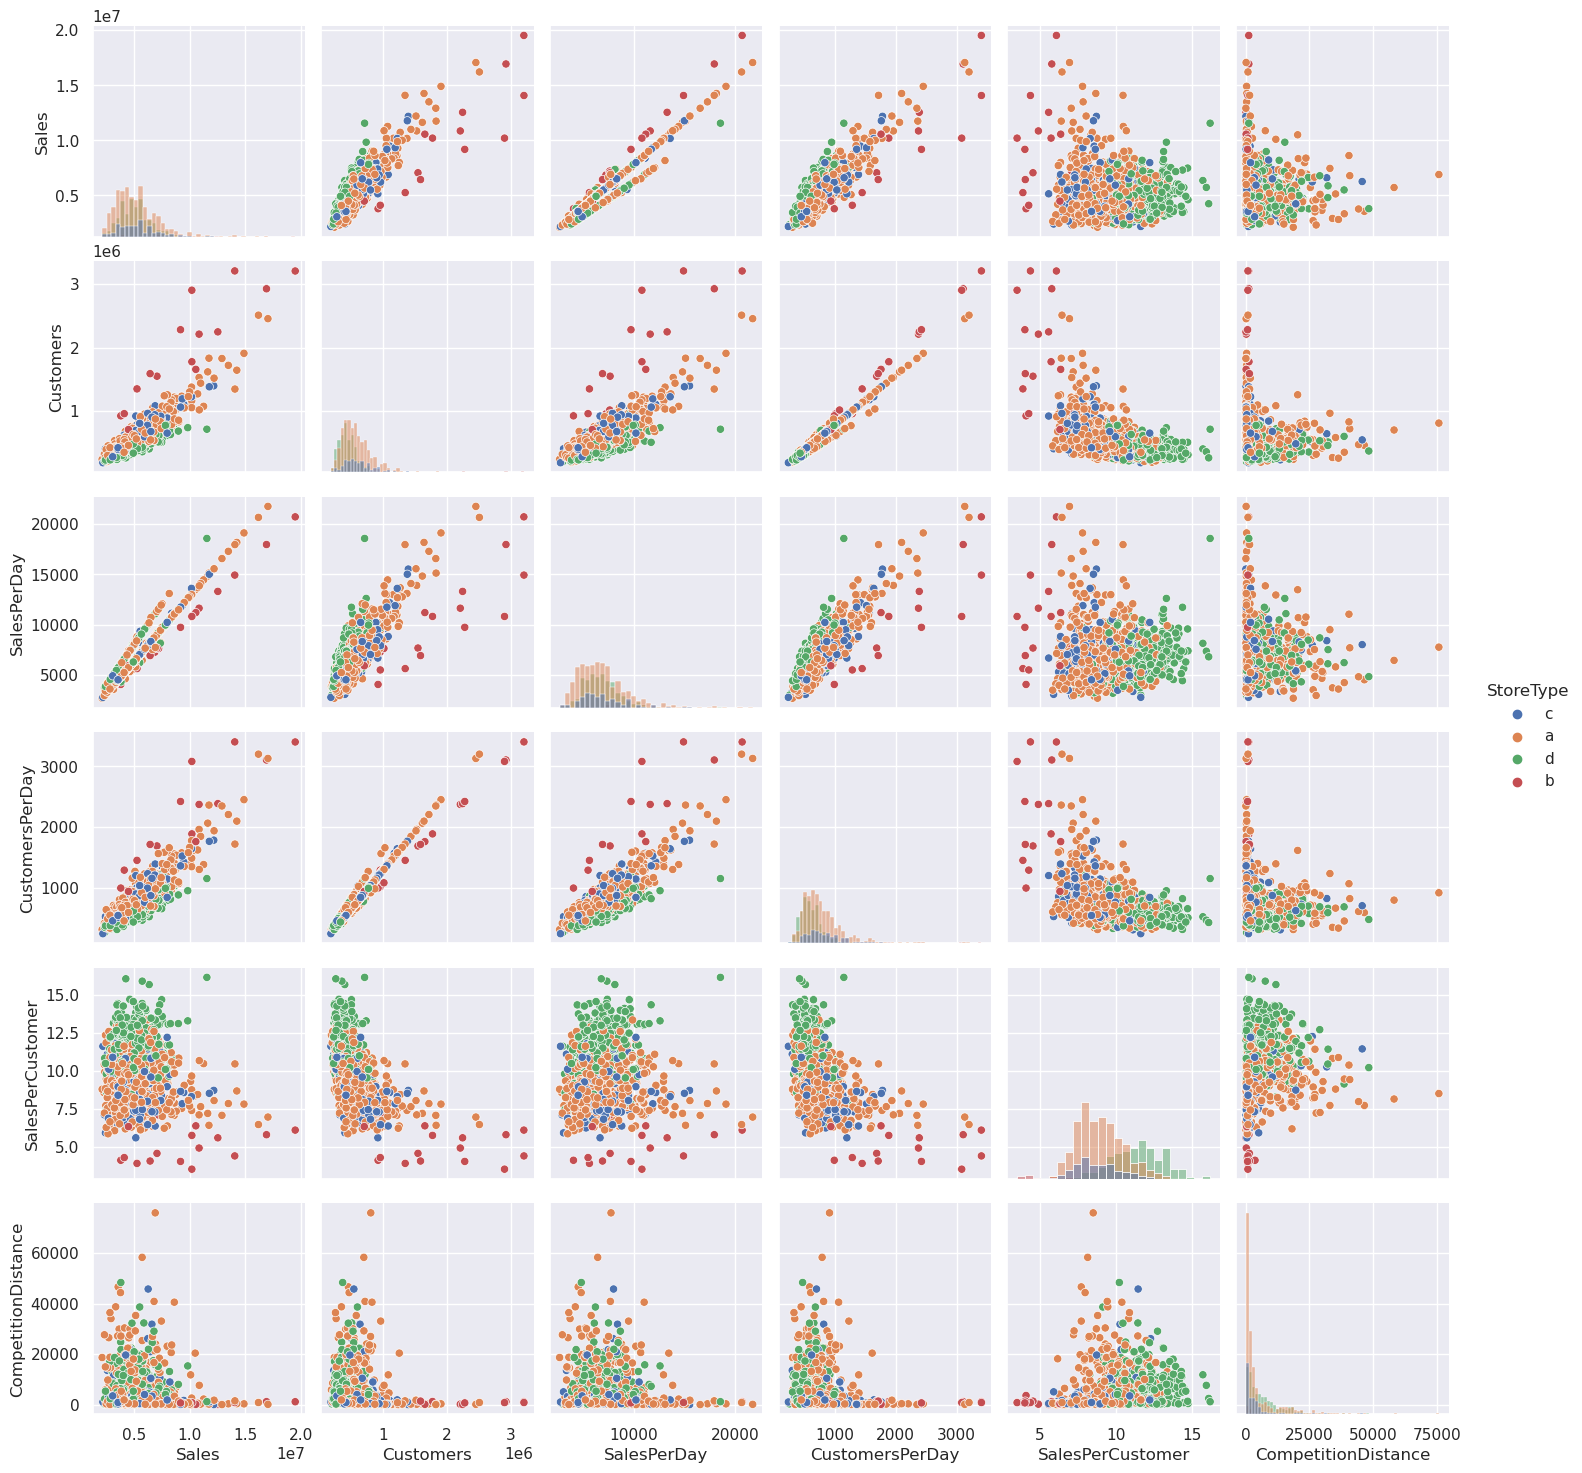

In [75]:
sns.pairplot(data=train_stores.iloc[:,[0,1,6,7,8,11,9]],diag_kind='hist',hue='StoreType');

1. Abbildung<br>
Paarweise sind absoluter Umsatz, Kunden, Umsatz sowie Kunden pro Tag, Umsatz pro Kunde und die Entfernung zum nächsten Konkurrenz-Geschäft ins Verhältnis gesetzt.<br>
Farblich hervorgehoben sind die vier verschiedenen Store-Modelle.

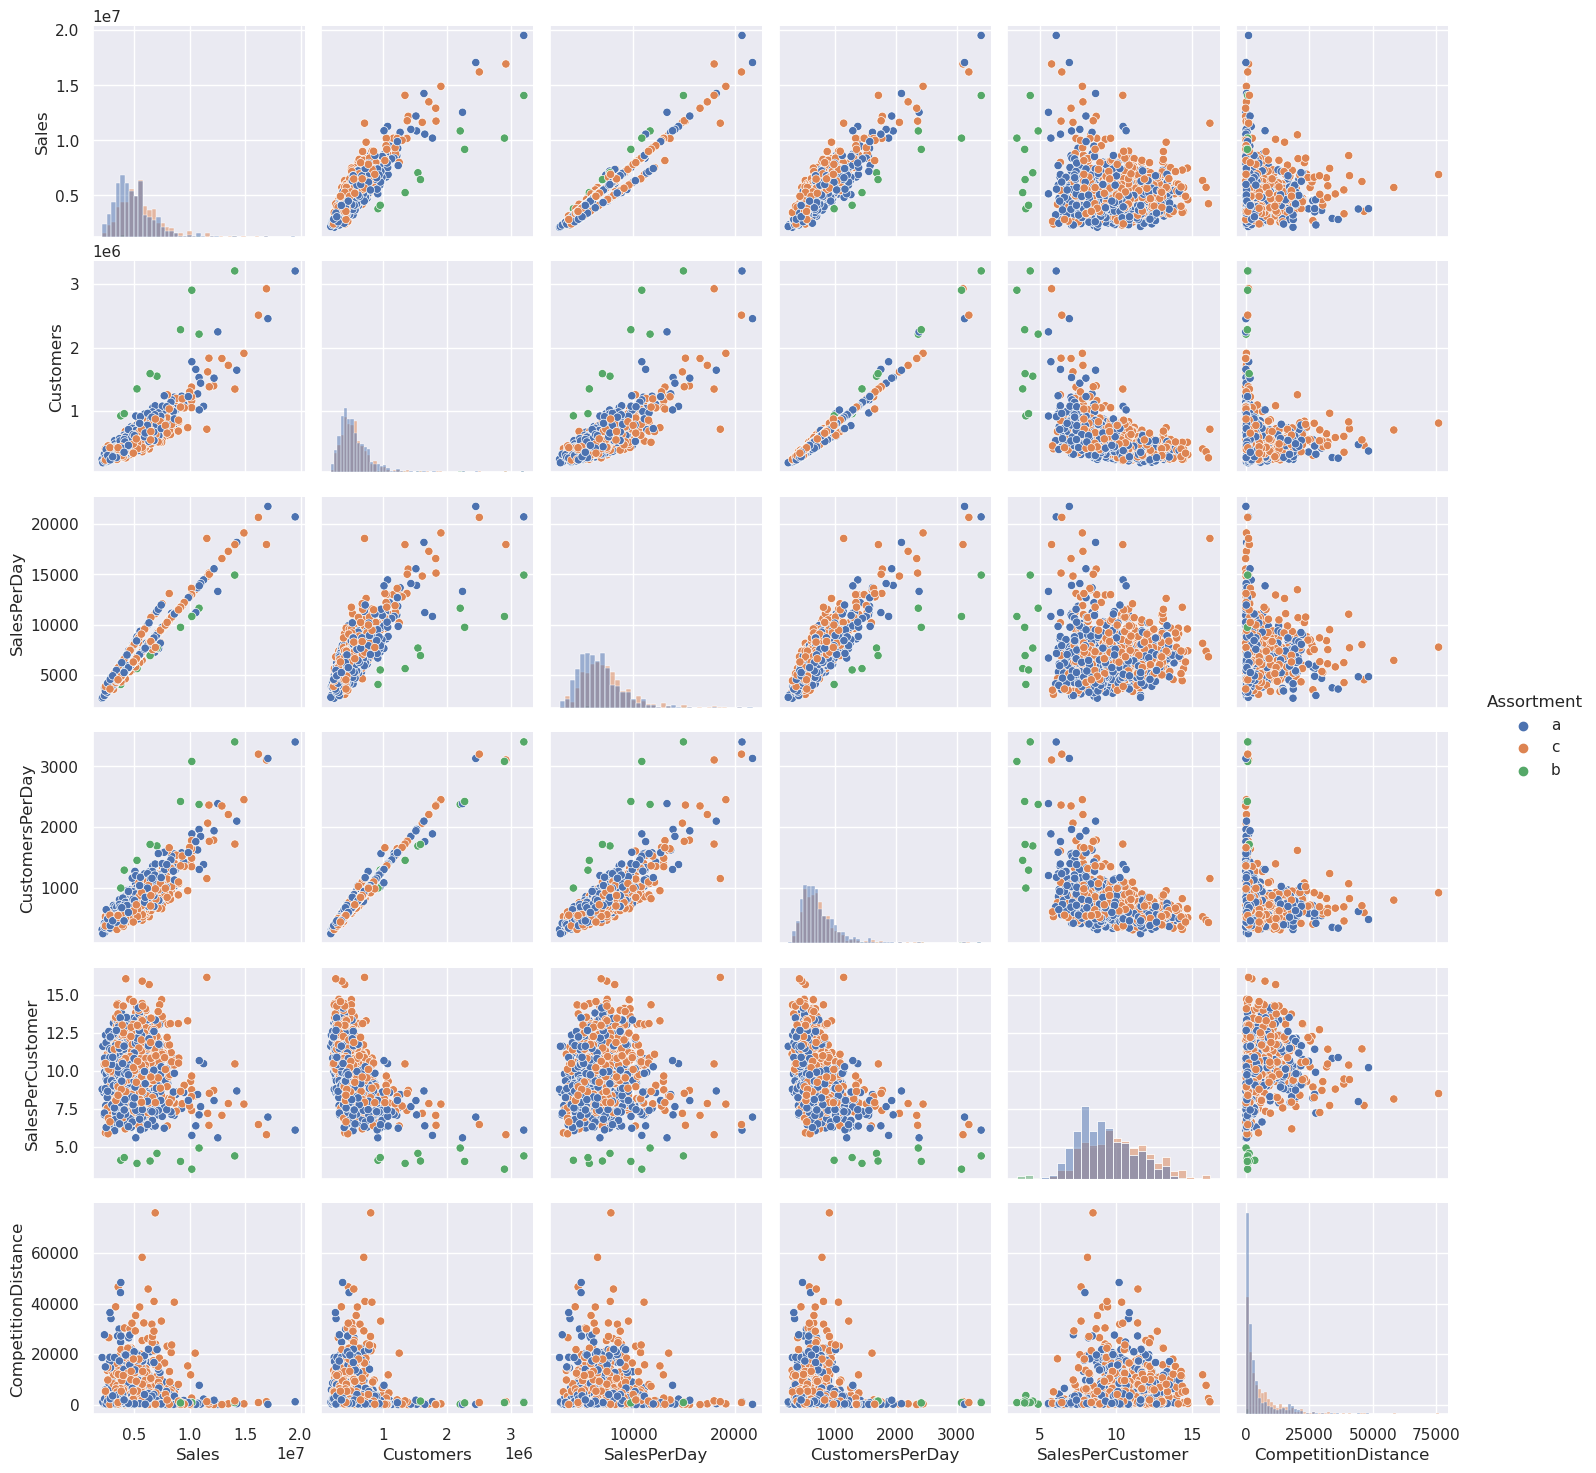

In [76]:
sns.pairplot(data=train_stores.iloc[:,[0,1,6,7,8,11,10]],diag_kind='hist',hue='Assortment');

2. Abbildung<br>
Paarweise sind absoluter Umsatz, Kunden, Umsatz sowie Kunden pro Tag, Umsatz pro Kunde und die Entfernung zum nächsten Konkurrenz-Geschäft ins Verhältnis gesetzt.<br>
Die Einfärbung gibt den Sortiments-Typ wieder.

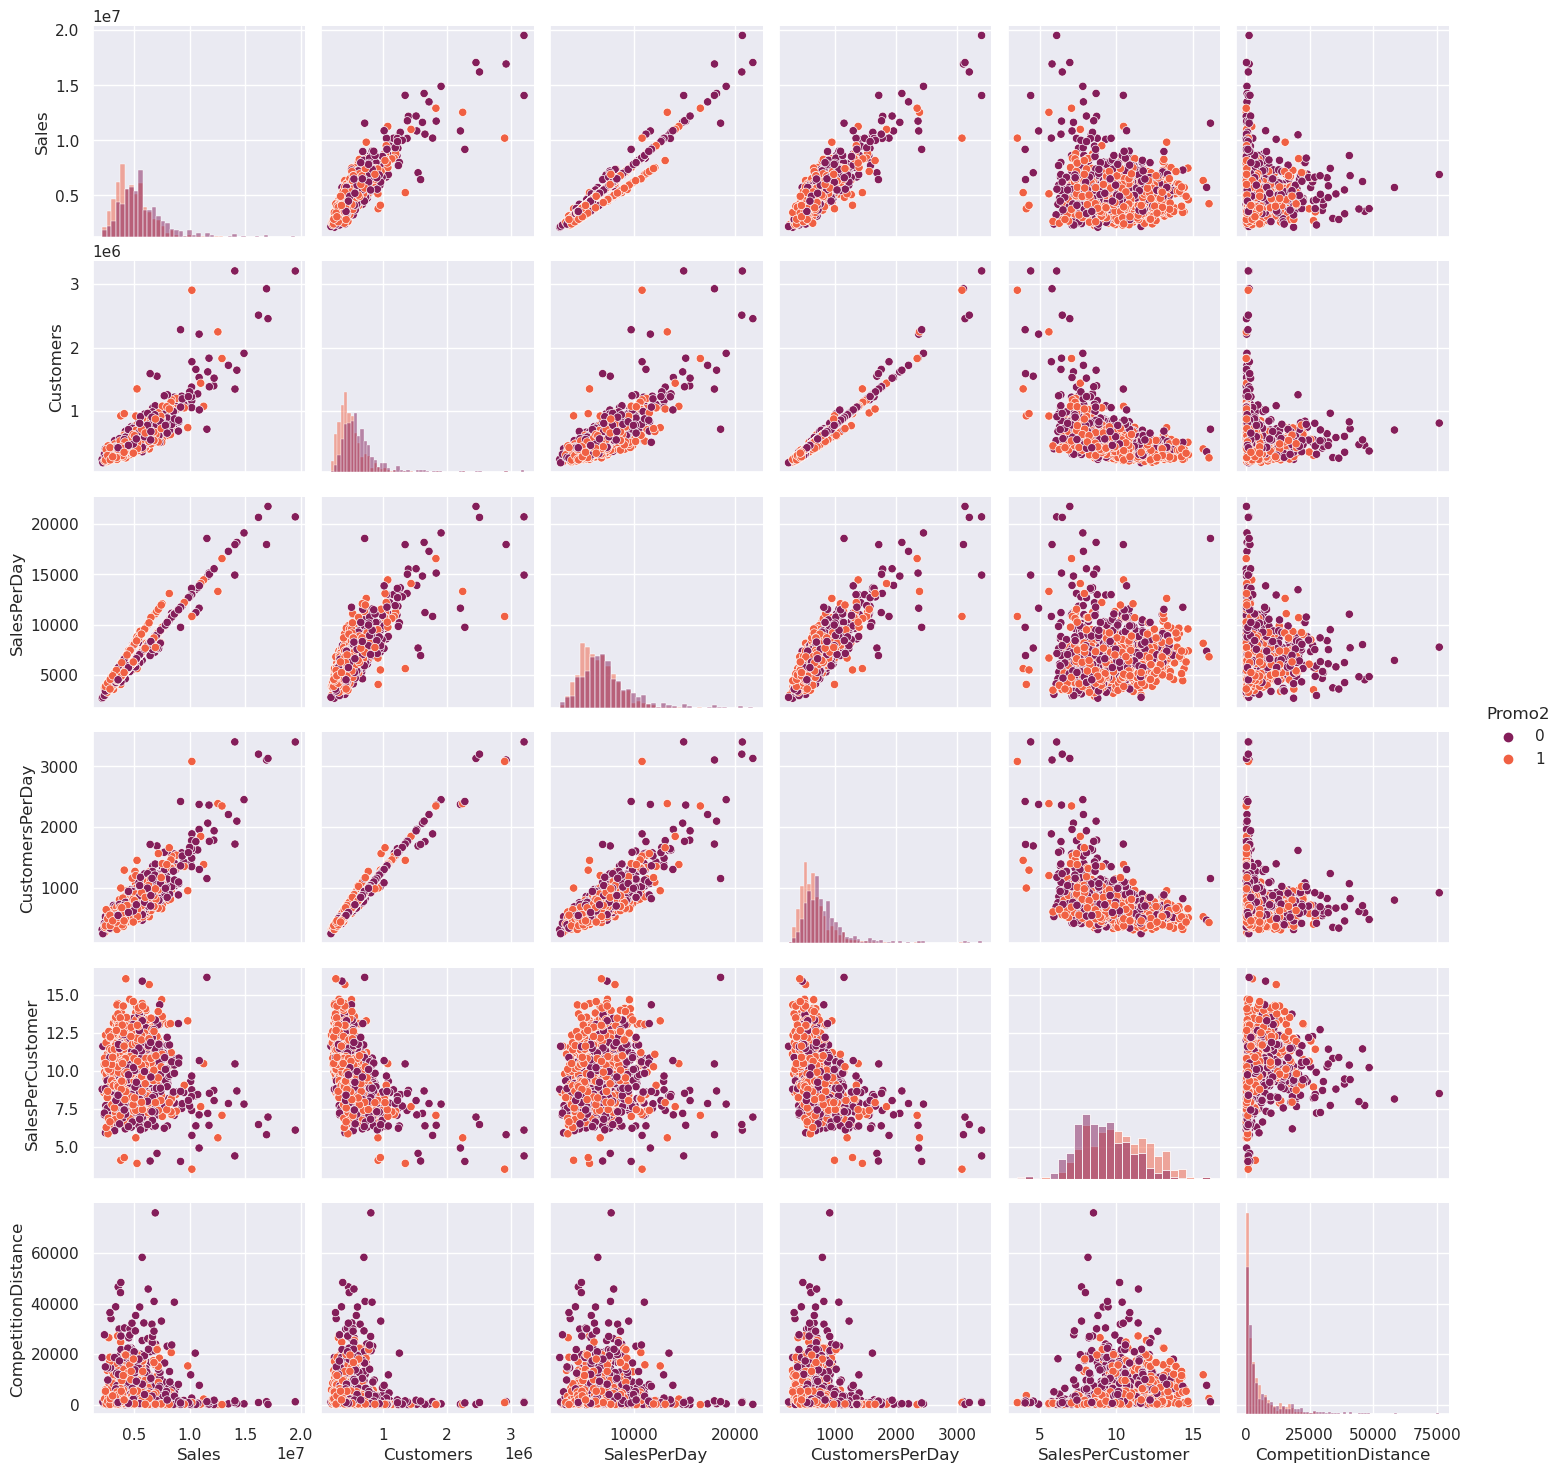

In [77]:
sns.pairplot(data=train_stores.iloc[:,[0,1,6,7,8,11,14]],diag_kind='hist',hue='Promo2', palette='rocket');

3. Abbildung<br>
Paarweise sind absoluter Umsatz, Kunden, Umsatz sowie Kunden pro Tag, Umsatz pro Kunde und die Entfernung zum nächsten Konkurrenz-Geschäft ins Verhältnis gesetzt.<br>
Die Einfärbung folgt je nachdem, ob eine Promo2-Aktion stattgefunden hat.

Selbstverständlich besteht ein linearer Zusammenhang zwischen Sales bzw. Customers und SalesPerDay und CustomersPerDay. Auffällig ist aber, dass dieser sich jeweils in drei Stränge auffächert. Diese Stränge lassen sich bestimmten Filial- und Sortimentstypen zuordnen.<br>
Promo2 korrelliert bei den Kunden- und Verkaufszahlen mit Abweichungen nach oben.<br>
Je weniger Kunden ein Store pro Tag hat, desto höher sind die Verkäufe pro Kunde.<br>
Mehr Kunden pro Tag gehen mit näherer Konkurrenz einher, dies ist ein Merkmal von Ballungsräumen.<br>

# 02. Modellbildung

In [78]:
#Eingabe der Filial-ID
store_nr=798
#Festlegung des random_state
rds=8

Zunächst versuchen wir ein Entscheidungsbaum-Modell.<br>
Anschließend geht es in den Random-Forest. Hier und beim folgenden Modell werden anhand der Gittersuche (mit CV) unterschiedliche Parameter durchlaufen.<br>
Es folgt eine Support Vector Machine, hier ist eine Umskalierung erforderlich.<br>
Wie schneidet im Vergleich ein einfaches, lineares Modell ab?<br>
Zwar schneidet die lineare Regression in der Vorhersage schwächer ab als komplexere Modelle, anhand ihrer lässt sich jedoch gut die unterschiedliche Relevanz der einzelnen Variablen verdeutlichen.

In [79]:
def modell(store_nr):
    
#Erstellen der Trainings- und Testdaten
    X_train,X_test,y_train,y_test=train_test_split(train_weekly.loc[store_nr,'Customers':],train_weekly.loc[store_nr,'Sales'],test_size=8,random_state=rds)

#Erstelle zum Test einen Dummy für die Zielvariable mit dem historischen Mittelwert
    hist_av_nr=int(train_weekly.loc[store_nr,'Sales'].mean())*np.ones(8,dtype='int64')
    y_dum=pd.Series(hist_av_nr,y_test.index, name='Sales')

#Funktion zur Ausgabe der einschlägigen Regressionsmetriken
    def vergleich(y_test,y_pred_nr,y_dum):

        MSE_pred = mean_squared_error(y_test, y_pred_nr)
        MSE_dum = mean_squared_error(y_dum, y_test)
        print('MSE Vorhersage: {a:.0f}'.format(a=np.sqrt(MSE_pred)))
        print('MSE Dummy: {a:.0f}'.format(a=np.sqrt(MSE_dum)))
        print(30*'-')

        MAE_pred = mean_absolute_error(y_pred_nr, y_test)
        MAE_dum = mean_absolute_error(y_dum, y_test)
        print('MAE Vorhersage: {a:.0f}'.format(a=MAE_pred))
        print('MAE Dummy: {a:.0f}'.format(a=MAE_dum))
        print(30*'-')

        R2_pred = r2_score(y_pred_nr, y_test)
        R2_dum = r2_score(y_dum, y_test)
        print('R2 Vorhersage: {a:.5f}'.format(a=R2_pred))

#Funktion zur Ausgabe der Umsatz-Prognose
    def orakel(X_test,y_pred_nr):
        k=0
        for i in X_test.index.strftime('%d-%m-%Y'):
            print('Die Woche zum {a} schließt mit einem Umsatz von: {b:.0f}€.'.format(a=i,b=y_pred_nr[k]))
            k+=1
    print('Store Nr. {a}'.format(a=store_nr))
    print(30*'*')

    
#!!!!!Fitten des Entscheidungsbaum-Modells
    dtr=DecisionTreeRegressor(random_state=rds,max_depth=7)
    dtr.fit(X_train,y_train)
#Vorhersage auf den Test-Daten
    y_pred_nr=dtr.predict(X_test)
#Wie schneidet das Modell ab?
    print('Decision Tree Regressor:')
    print('-'*30)
    vergleich(y_test,y_pred_nr,y_dum)
    print(70*'-')
#Was prognostiziert es?
    orakel(X_test,y_pred_nr)
    print(70*'+')

    
#!!!!!Auswahl der zu probierenden Parameter und des Regressors
    params={'max_depth':[3,4,5,6],'n_estimators':[100,1000,2000]}
    grid_search2=GridSearchCV(RandomForestRegressor(random_state=rds),params,cv=4,return_train_score=True)
#Fitten und Vorhersagen
    grid_search2.fit(X_train, y_train)
    y_pred_nr2=grid_search2.predict(X_test)
#Wie schneidet das Modell ab?
    print('Random Forest Regressor mit Gittersuche:')
    print('-'*30)
    vergleich(y_test,y_pred_nr2,y_dum)
    print(70*'-')
#Was prognostiziert es?
    orakel(X_test,y_pred_nr2)
    print(70*'+')


#!!!!!!SVR Auswahl der zu probierenden Parameter und des Regressors
    params={'C':[0.0001,0.001,0.01,0.1,1,10,100,1000,5000],'gamma':[0.0001,0.001,0.01,0.1,1,10,100,1000,5000],'kernel':['linear','rbf'],'epsilon':[0.05,0.1,0.2,0.6,0,9] }
    grid_search3=GridSearchCV(SVR(),params,cv=5,return_train_score=True)
#Zusammenführen von Scaler und Gittersuche zu einer Pipeline
    regr3 = make_pipeline(MinMaxScaler(), grid_search3)
#Fitten und Vorhersagen
    regr3.fit(X_train, y_train)
    y_pred_nr3=regr3.predict(X_test)
#Wie schneidet das Modell ab?
    print('SVR mit Gittersuche:')
    print('-'*30)
    vergleich(y_test,y_pred_nr3,y_dum)
    print(70*'-')
#Was prognostiziert es?
    orakel(X_test,y_pred_nr3)
    print(70*'+')


#!!!!!!!Lineare Regression
    linreg=LinearRegression()
    scaler=StandardScaler()
    
    X_train_sca=scaler.fit_transform(X_train)
    X_test_sca=scaler.fit_transform(X_test)
    
    linreg.fit(X_train_sca,y_train)
    y_pred_nr4 = linreg.predict(X_test_sca)
#Wie schneidet das Modell ab?
    print('Lineare Regression:')
    print('-'*30)
    vergleich(y_test,y_pred_nr4,y_dum)
    print(70*'-')
#Was prognostiziert es?
    orakel(X_test,y_pred_nr4)
    print(70*'-')
#Grafik der Koeffizienten
    df2=pd.DataFrame(data=linreg.coef_, index=X_train.columns.values,columns=['Gewichtungen'])
    sns.barplot(data=df2,x='Gewichtungen',y=df2.index).set_title('Die Koeffizienten der linearen Regression');

Store Nr. 798
******************************
Decision Tree Regressor:
------------------------------
MSE Vorhersage: 1787
MSE Dummy: 8217
------------------------------
MAE Vorhersage: 1401
MAE Dummy: 7808
------------------------------
R2 Vorhersage: 0.95534
----------------------------------------------------------------------
Die Woche zum 26-07-2015 schließt mit einem Umsatz von: 33136€.
Die Woche zum 03-02-2013 schließt mit einem Umsatz von: 38503€.
Die Woche zum 09-06-2013 schließt mit einem Umsatz von: 47849€.
Die Woche zum 04-08-2013 schließt mit einem Umsatz von: 55081€.
Die Woche zum 11-05-2014 schließt mit einem Umsatz von: 50856€.
Die Woche zum 25-08-2013 schließt mit einem Umsatz von: 34295€.
Die Woche zum 28-07-2013 schließt mit einem Umsatz von: 33725€.
Die Woche zum 09-02-2014 schließt mit einem Umsatz von: 50856€.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Random Forest Regressor mit Gittersuche:
------------------------------
MSE Vorhersage

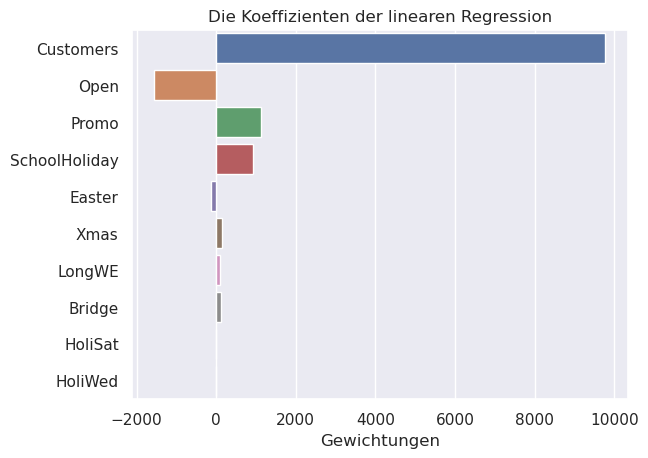

In [80]:
#Durchlaufen der Modelle, Ausgabe der Ergebnisse und Metriken
modell(store_nr)

# 03. Filialberichte

In [84]:
#Eingabe der Filial-ID
store_nr=133

In [93]:
def bericht(store_nr):
    print('Der Store mit der Filial-Nr. {a} ist ein Store vom Typ {b} mit Sortiment {c} und hat folgende Eckdaten:\n'.format(a=store_nr,
                                                                                                                            b=store.loc[store_nr,'StoreType'],
                                                                                                                            c=store.loc[store_nr,'Assortment']))
    print('Öffnungstage im Jahr {a}: {b}'.format(a=train_weekly.loc[store_nr,'Open'].resample('Y').sum().index.year[0],b=train_weekly.loc[store_nr,'Open'].resample('Y').sum()[0]))
    print('Öffnungstage im Jahr {a}: {b}\n'.format(a=train_weekly.loc[store_nr,'Open'].resample('Y').sum().index.year[1],b=train_weekly.loc[store_nr,'Open'].resample('Y').sum()[1]))
    for i in [0,1,2]:
        print('Im Jahr {a} war im Mittel ein Wochenumsatz von {b:.0f}€ bei {c:.0f} Kunden zu verzeichnen.'.
              format(a=train_weekly.loc[store_nr,'Sales'].resample('Y').mean().index.year[i],
                     b=train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[i],
                     c=train_weekly.loc[store_nr,'Customers'].resample('Y').mean()[i]))
    print()
    if (train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[0]<train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[2]):
        print('Dies entspricht einer durchschnittlichen Umsatz-Steigerung von: {a:.0f}€ bzw. {b:.2f}%'.format(a=train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[2]-train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[0],
                                                                                                      b=100*(train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[2]-train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[0])/train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[0]))
        
        print()
    if train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[0]>train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[2]:
        print('Dies entspricht einem durchschnittlichen Umsatz-Rückgang von: {a:.0f}€ bzw. {b:.2f}%'.format(a=train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[0]-train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[2],
                                                                                                      b=100*(train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[0]-train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[2])/train_weekly.loc[store_nr,'Sales'].resample('Y').mean()[2]))
        print()
    if stores.loc[store_nr,'CompetitionOpenSinceYear'] >= 2013:
        print('Eine Konkurrenz-Filiale hat {b}. {a} in {c}m Entfernung eröffnet.\n'.format(a=stores.loc[store_nr,'CompetitionOpenSinceYear'],
                                                                                          b=stores.loc[store_nr,'CompetitionOpenSinceMonth'],
                                                                                          c=stores.loc[store_nr,'CompetitionDistance']))
            
    print('Die folgende Grafik zeigt den Einfluss der wöchentlichen Promo-Aktionen auf die Verkaufszahlen:\n')
    
    fig,g=plt.subplots(1,2,figsize=(15,6))
    plt.subplot(1,2,1)
    g[0]=sns.scatterplot(data=train_weekly.loc[store_nr,:],y='Sales',x=train_weekly.loc[store_nr,:].index,hue='Promo',palette='rocket')
    g[0].set_title('Umsatz aufgeschlüsselt nach Promo')
    g[0].set_ylabel('in €')
    g[0].set_xlabel('Datum')
    plt.subplot(1,2,2)
    g[1]=sns.scatterplot(data=train_weekly.loc[store_nr,:],y='Customers',x=train_weekly.loc[store_nr,:].index,hue='Promo',palette='rocket')
    g[1].set_title('Kunden aufgeschlüsselt nach Promo')
    g[1].set_ylabel('Kunden')
    g[1].set_xlabel('Datum')
    fig.autofmt_xdate()
    plt.tight_layout()

Der Store mit der Filial-Nr. 133 ist ein Store vom Typ a mit Sortiment a und hat folgende Eckdaten:

Öffnungstage im Jahr 2013: 301
Öffnungstage im Jahr 2014: 302

Im Jahr 2013 war im Mittel ein Wochenumsatz von 39950€ bei 4795 Kunden zu verzeichnen.
Im Jahr 2014 war im Mittel ein Wochenumsatz von 36307€ bei 4263 Kunden zu verzeichnen.
Im Jahr 2015 war im Mittel ein Wochenumsatz von 35241€ bei 3948 Kunden zu verzeichnen.

Dies entspricht einem durchschnittlichen Umsatz-Rückgang von: 4709€ bzw. 13.36%

Eine Konkurrenz-Filiale hat 8. 2013 in 270m Entfernung eröffnet.

Die folgende Grafik zeigt den Einfluss der wöchentlichen Promo-Aktionen auf die Verkaufszahlen:



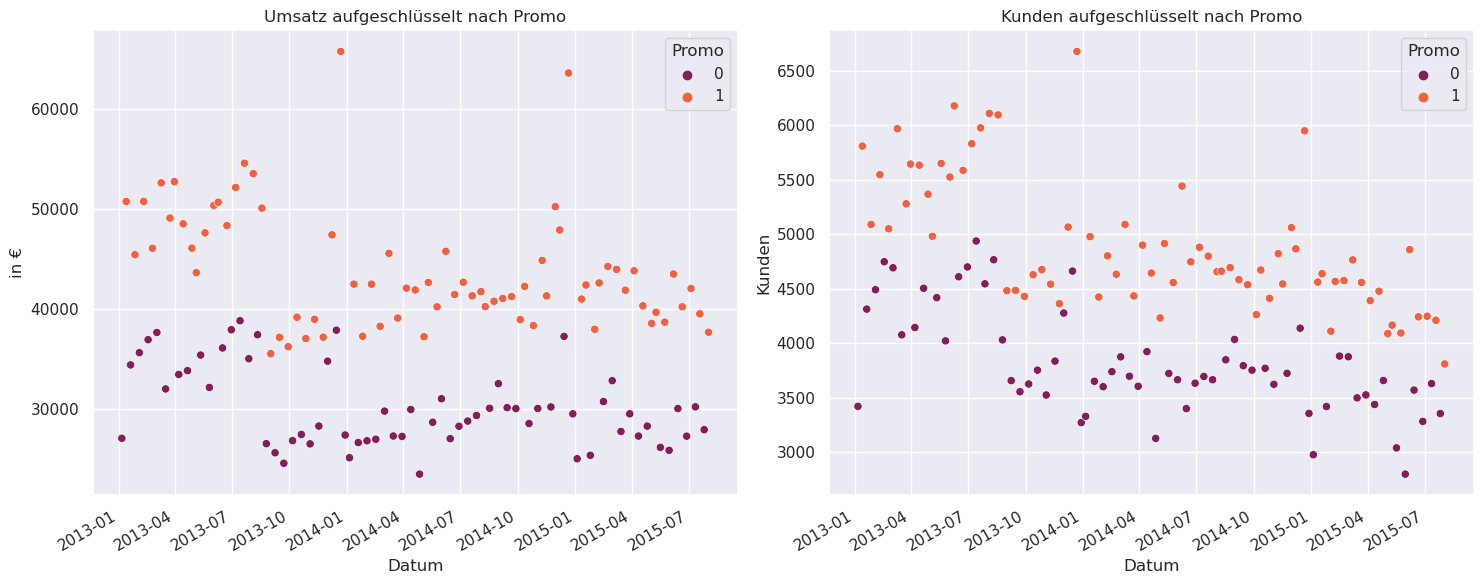

In [94]:
#Ausgabe des Berichts
bericht(store_nr)